In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import numpy as np
import torch
import scipy
import sklearn
from typing import Union

from emle.models import EMLE
from emle.train._utils import pad_to_max
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, kendalltau

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [8]:
# Adapted from https://github.com/OpenFreeEnergy/cinnabar/blob/26eecb75bdbb5d7baf8798615feed16effe62abb/cinnabar/stats.py#L8
def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 100,
    plot_type: str = "dG",
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:
    """
    Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == "MUE":
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "MSE":
            # mean signed error
            return np.mean(y_pred_sample - y_true_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                y_true_sample, y_pred_sample
            )
            return r_value**2
        elif statistic == "rho":
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros(
        [nbootstrap], np.float64
    )  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i, j in enumerate(
            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
        ):
            stddev_true = np.fabs(dy_true[j]) if include_true_uncertainty else 0
            stddev_pred = np.fabs(dy_pred[j]) if include_pred_uncertainty else 0
            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=stddev_true, size=1)
            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=stddev_pred, size=1)
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0 - ci) / 2.0
    high_frac = 1.0 - low_frac
    rmse_stats["low"] = s_n[int(np.floor(nbootstrap * low_frac))]
    rmse_stats["high"] = s_n[int(np.ceil(nbootstrap * high_frac))]

    return rmse_stats


In [3]:
# Set the path to the models
source_path = "../../../../"

models_dict = {
    "General Model": source_path + "emle_models/emle_qm7_aev.mat",
    "Bespoke Model": source_path + "emle_models/ligand_bespoke_iter2.mat",
    "Patched Model": source_path + "emle_models/ligand_patched_species_iter2.mat"
}

In [4]:
# Load the testing data 
testing_data = [
    source_path + "data/testing_training_data/merged_testing_data_iter_1.pkl",
    source_path + "data/testing_training_data/merged_testing_data_iter_2.pkl",
    source_path + "data/testing_training_data/merged_testing_data_iter_3.pkl",
]

xyz_qm = []
xyz_mm = []
z = []
charges_mm = []
e_static_ref = []
e_ind_ref = []

for data in testing_data:
    testing_data = pkl.load(open(data, "rb"))
    xyz_qm += testing_data["xyz_qm"]
    xyz_mm += testing_data["xyz_mm"]
    z += testing_data["z"]
    charges_mm += testing_data["charges_mm"]
    e_static_ref += testing_data["e_static"]
    e_ind_ref += testing_data["e_ind"]

# Pad to max and convert to torch tensors
xyz_qm = pad_to_max(xyz_qm)
xyz_mm = pad_to_max(xyz_mm)
z = pad_to_max(z)
charges_mm = pad_to_max(charges_mm)
e_static_ref = torch.tensor(e_static_ref)
e_ind_ref = torch.tensor(e_ind_ref)

In [5]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}

HARTEE_TO_KJ_MOL = 2625.5
for model_name, model_path in models_dict.items():
    emle_model = EMLE(model=model_path, alpha_mode="species").double()

    e_static_emle, e_ind_emle = emle_model.forward(
        z,
        charges_mm,
        xyz_qm,
        xyz_mm,
    )

    e_static_emle = e_static_emle.detach().cpu().numpy()
    e_ind_emle = e_ind_emle.detach().cpu().numpy()

    emle_energy_dict[model_name] = {
        "e_static_emle": e_static_emle * HARTEE_TO_KJ_MOL,
        "e_ind_emle": e_ind_emle * HARTEE_TO_KJ_MOL,
    }


with open("emle_energy_dict.pkl", "wb") as f:
    pkl.dump(emle_energy_dict, f)

In [6]:
def compute_metrics(true_values, predicted_values):
    """Compute the mean unsigned error (MUE), mean signed error (MSE), spearmans rho, Kendall's tau, and R2 score."""
    
    rmse = np.sqrt(np.mean((predicted_values - true_values) ** 2))
    mue = np.mean(np.abs(predicted_values - true_values))
    mse = np.mean(predicted_values - true_values)
    kendall = kendalltau(true_values, predicted_values)[0]
    pearson = pearsonr(true_values, predicted_values)[0]
    r2 = r2_score(true_values, predicted_values)

    return mue, mse, kendall, pearson, r2, rmse

/tmp/ipykernel_3040881/4192766927.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true_sample[i] = np.random.normal(loc=y_true[j], scale=stddev_true, size=1)
/tmp/ipykernel_3040881/4192766927.py:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=stddev_pred, size=1)
/tmp/ipykernel_3040881/4192766927.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true_sample[i] = np.random.normal(loc=y_true[j]

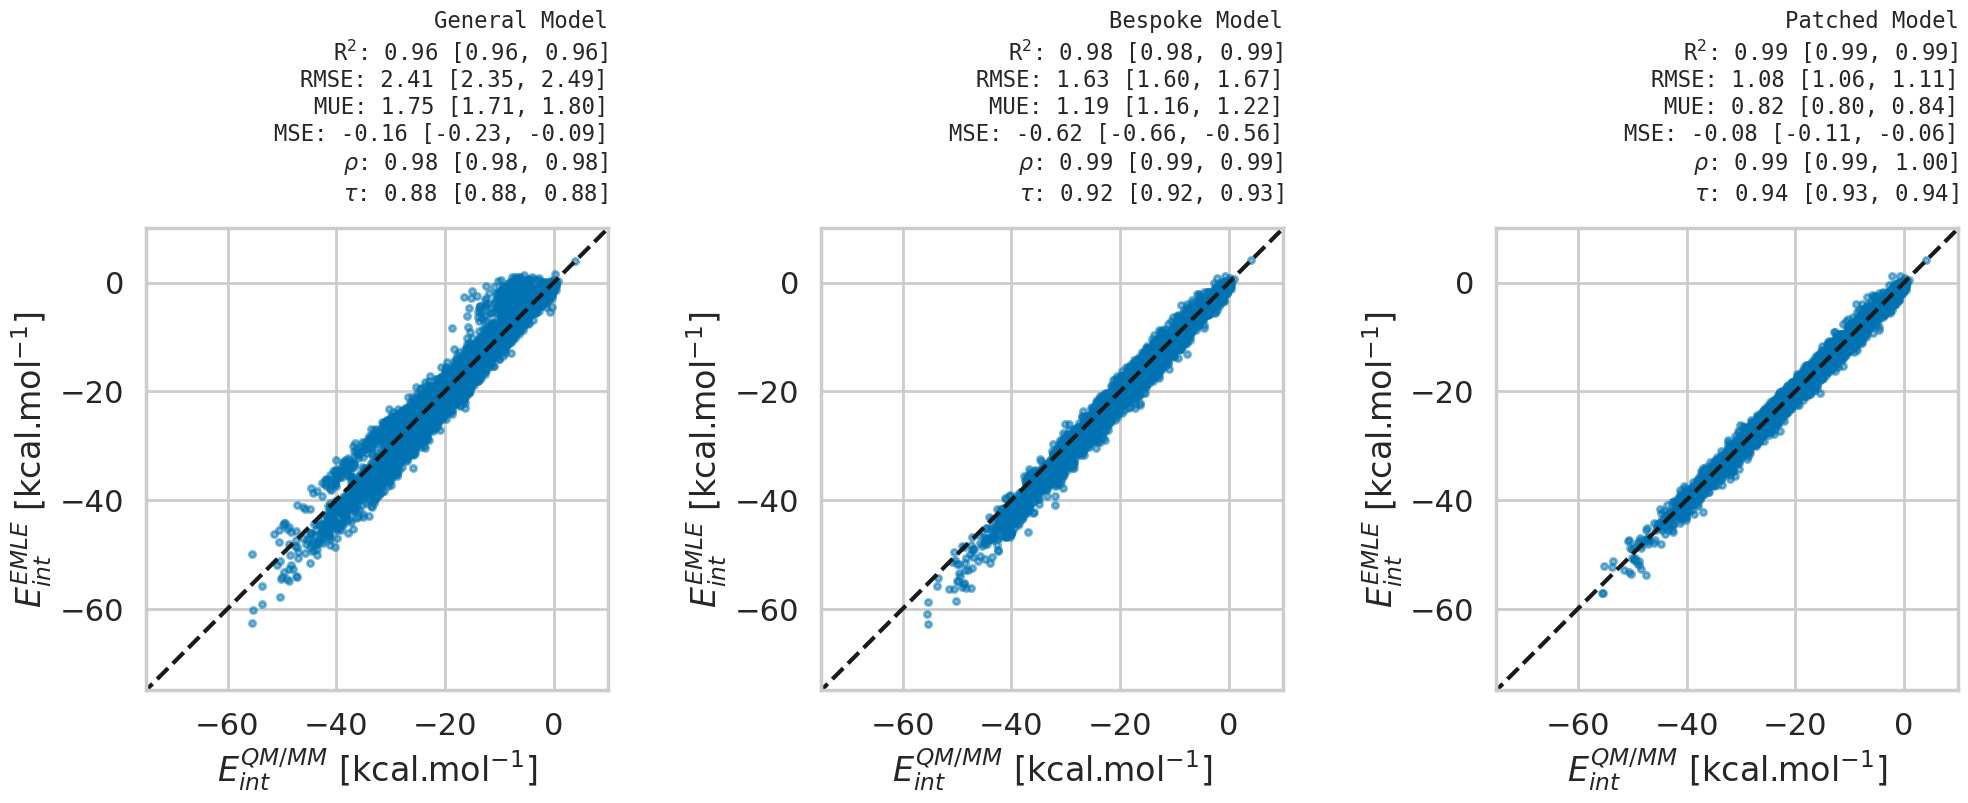

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid", palette="colorblind", context="poster")
fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharex=True, sharey=False) 

x = np.linspace(-1000, 1000, 100)
y = x

xlims = (-75, 10)
ylims = (-75, 10)

for i, (model_name, emle_energy) in enumerate(emle_energy_dict.items()):
    axes[i].set_aspect("equal")
    axes[i].set_xlim(*xlims)
    axes[i].set_ylim(*ylims)
    axes[i].plot(x, y, "k--", label="Reference Line")

    predicted = emle_energy["e_static_emle"]+ emle_energy["e_ind_emle"]
    reference = e_static_ref.numpy() + e_ind_ref.numpy()

    predicted = predicted / 4.184
    reference = reference / 4.184

    # Bootstrap statistics ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    metrics = ['R2', 'RMSE', 'MUE', 'MSE', 'rho','KTAU']
    statistics = {}
    statistics_string = ""
    statistic_type = "mle"
    statistic_name = {
        "RMSE": r"RMSE",
        "MUE": r"MUE",
        "MSE": r"MSE",
        "R2": r"R$^2$",
        "rho": r"$\rho$",
        "KTAU": r"$\tau$",
    }
    for statistic in metrics:
        statistics[statistic] = bootstrap_statistic(reference, predicted, statistic=statistic)
        s = statistics[statistic]
        string = f"{statistic_name[statistic]}: {s[statistic_type]:.2f} [{s['low']:.2f}, {s['high']:.2f}]" + "\n"
        statistics_string += string

    scatter = axes[i].scatter(reference, predicted, cmap='Blues', label="Static", alpha=0.5, s=20)

    axes[i].set_xlabel("$E^{QM/MM}_{int}$ [kcal.mol$^{-1}]$")
    #axes[i].set_ylabel("$E^{EMLE}$ [kcal.mol$^{-1}]$")
    axes[i].set_title(f'{model_name}\n{statistics_string}', loc='right', horizontalalignment='right', family='monospace', fontsize=16, pad=1)


axes[0].set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}]$")
axes[1].set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}]$")
axes[2].set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}]$")


plt.subplots_adjust(wspace=0.15)  # Removes horizontal space between subplots
plt.savefig("fig_model_performance.pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()